In [11]:
import torch
import numpy as np

# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

torch.Size([1, 1, 512, 512])


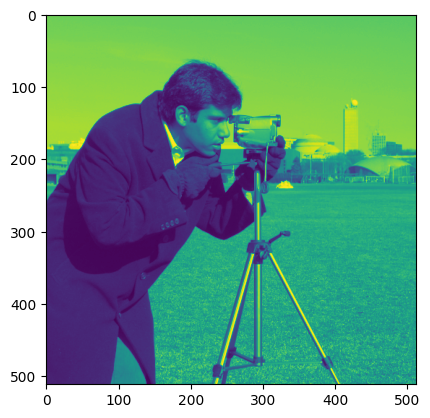

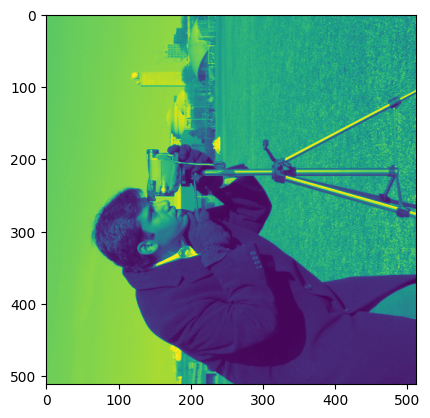

In [12]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import kornia as K
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale

from skimage import data

camera = K.image_to_tensor(data.camera(), keepdim=False)
camera = camera.float() / 255.
print(camera.shape)
timg = torch.cat([camera,torch.rot90(camera,1,dims=(2,3))], dim=0)
timg_gray = timg


plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

## Aumento de dados caminho de ida e volta e reprodutibilidade

In [13]:
import kornia

class AugmentationParamsGenerator:
    def __init__(self, n, shape):
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        
        aug_list = kornia.augmentation.AugmentationSequential(
            kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
            kornia.augmentation.RandomPerspective(0.1, p=0.7),
            kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
            # kornia.augmentation.RandomEqualize(p=0.3),
            data_keys=["input"],
            same_on_batch=True,
            # random_apply=10,
        )

        self.index = 0
        self.data = []
        for i in range(n):
            out = aug_list(torch.rand(shape))
            self.data.append(aug_list._params)

    def __iter__(self):
        return self

    def __next__(self):
        if self.index >= len(self.data):
            self.index = 0  # Reset index to start over for circular iteration
            
        result = self.data[self.index]
        self.index += 1
        return result


def generate_random_points(image_size, num_points):
    # Extrair as dimensões da imagem
    H, W = image_size

    # Gerar tensores de coordenadas aleatórias
    random_coords = torch.rand(num_points, 2)

    # Dimensionar as coordenadas aleatórias de acordo com as dimensões da imagem
    random_coords[:, 0] *= W
    random_coords[:, 1] *= H

    return random_coords

In [14]:
import matplotlib.pyplot as plt
import kornia
def plot_images_with_points_side_by_side(image1, image2, points1=None, points2=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Cria uma figura com duas subplots

    # Converte tensores para imagens
    image1 = kornia.utils.tensor_to_image(image1)
    image2 = kornia.utils.tensor_to_image(image2)

    # Plot da primeira imagem na subplot da esquerda
    axs[0].imshow(image1)
    if points1 is not None:
        points1 = points1.cpu().numpy()  # Converte para numpy
        keypoints_x = points1[:,0].flatten().tolist()
        keypoints_y = points1[:,1].flatten().tolist()
        axs[0].scatter(keypoints_x, keypoints_y, c='red', marker='x')  # Plota os pontos em vermelho com marcador 'x'
    axs[0].axis('off')  # Remove os eixos

    # Plot da segunda imagem na subplot da direita
    axs[1].imshow(image2)
    if points2 is not None:
        points2 = points2.cpu().numpy()  # Converte para numpy
        keypoints_x = points2[:,0].flatten().tolist()
        keypoints_y = points2[:,1].flatten().tolist()
        axs[1].scatter(keypoints_x, keypoints_y, c='red', marker='x')
    axs[1].axis('off')  # Remove os eixos

    plt.show()  # Mostra o plot com as duas imagens lado a lado


def filtrar_keypoints(lista_de_pontos, tensor_mascara):
    # Verificar se as coordenadas estão dentro das dimensões
    dimensao_max_x, dimensao_max_y = tensor_mascara.shape[1] - 1, tensor_mascara.shape[0] - 1
    pontos_filtrados = [
        1  if 0 <= p1[0] <= dimensao_max_x 
        and 0 <= p1[1] <= dimensao_max_y 
        and tensor_mascara[int(p1[1]), int(p1[0])] else 0 for p1 in lista_de_pontos
    ]
    pontos_filtrados = torch.tensor(pontos_filtrados, dtype=torch.bool)
    lista_de_pontos = torch.tensor(lista_de_pontos)
    return lista_de_pontos[pontos_filtrados],pontos_filtrados

In [15]:
import kornia

img1: torch.Tensor = kornia.image_to_tensor(data.camera(), keepdim=False).float() / 255.
input = torch.cat([img1,img1], dim=0)
B,C,H,W = input.shape
mask = torch.ones(B,C,H,W)
border_size =20
mask[:, :, :border_size, :] = 0
mask[:, :, -border_size:, :] = 0
mask[:, :, :, :border_size] = 0
mask[:, :, :, -border_size:] = 0

bbox = torch.tensor([[
    [1., 1.],
    [2., 1.],
    [2., 2.],
    [1., 2.],
]]).expand(B, 1, -1, -1)

points = generate_random_points((H,W),30).expand(2, -1, -1)
shape = input.shape
params_lists =AugmentationParamsGenerator(6,shape)
next_item = next(params_lists)


torch.Size([30, 2])
params_lists  6


/tmp/ipykernel_65145/75368688.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lista_de_pontos = torch.tensor(lista_de_pontos)


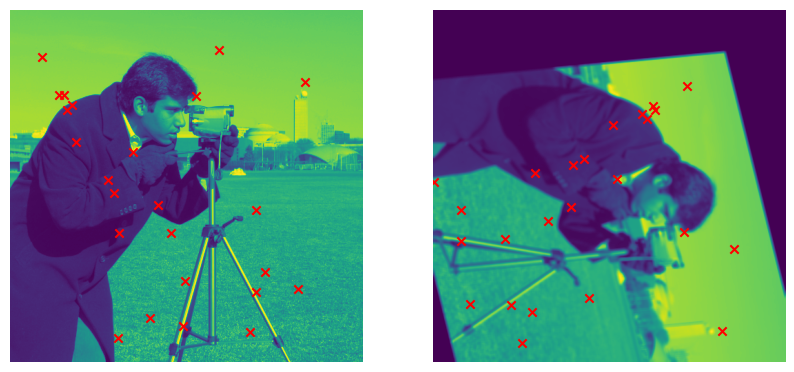

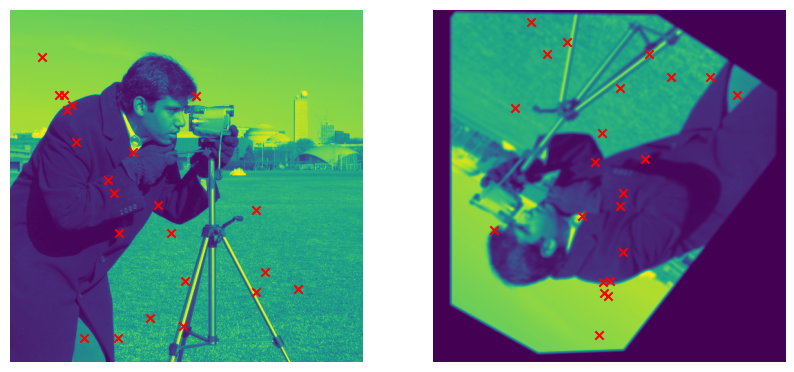

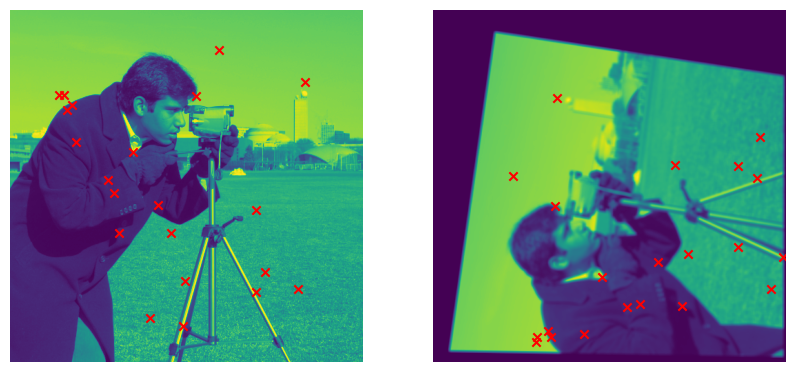

In [135]:
aug_list = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
    kornia.augmentation.RandomPerspective(0.1, p=0.7),
    kornia.augmentation.RandomBoxBlur((5,5),p=0.7),
    # kornia.augmentation.RandomEqualize(p=0.3),
    data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=True,
    # random_apply=15,
)

print(points[0].shape)
# plot_image_with_keypoints(input[0],points[0])

print('params_lists ',len(params_lists.data))
for i in range(3):
    params_item = next(params_lists)
    out = aug_list(input, mask, bbox, points,params=params_item)
    filtered_points,indices = filtrar_keypoints(out[3][0],out[1][0,0].bool())
    
    plot_images_with_points_side_by_side(input[0],out[0][0],points[0][indices],filtered_points)
    
out_inv = aug_list.inverse(*out)

torch.Size([10, 2])
torch.Size([1, 1, 512, 512]) torch.Size([1, 512, 512])
lafs1  torch.Size([1, 10, 2, 3]) torch.Size([1, 1, 512, 512])
lafs2  torch.Size([1, 10, 2, 3]) torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512]) torch.Size([1, 512, 512])
10


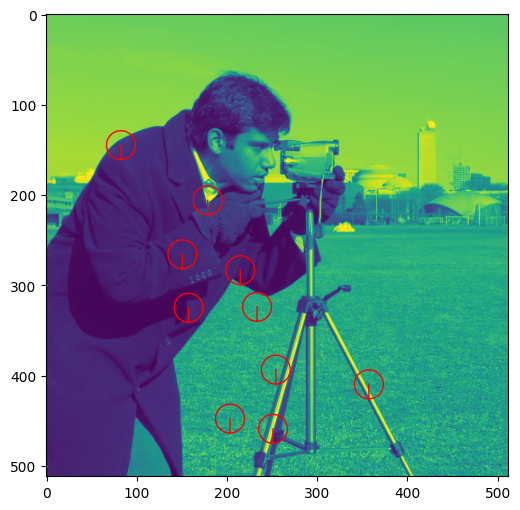

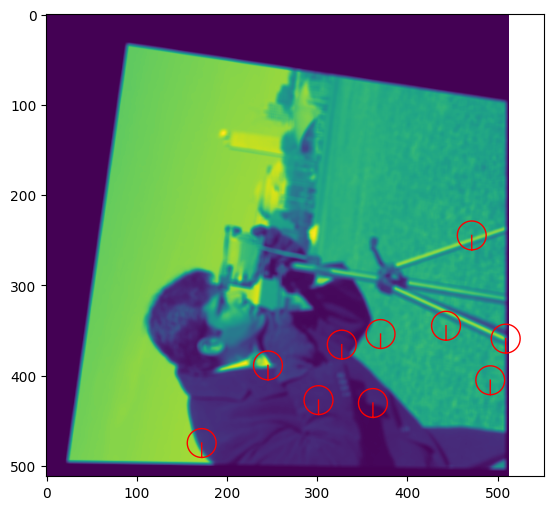

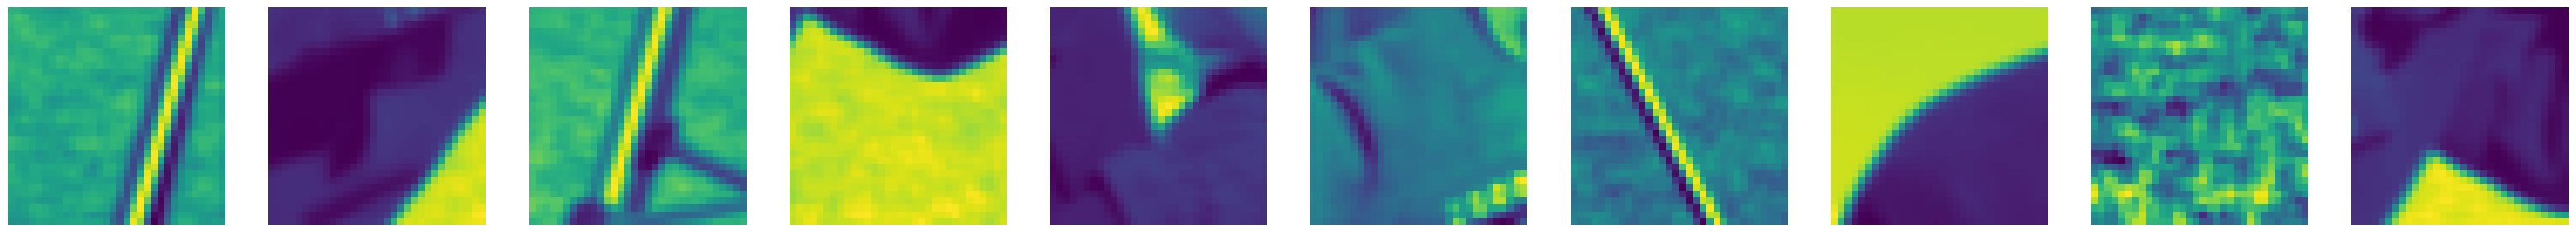

10


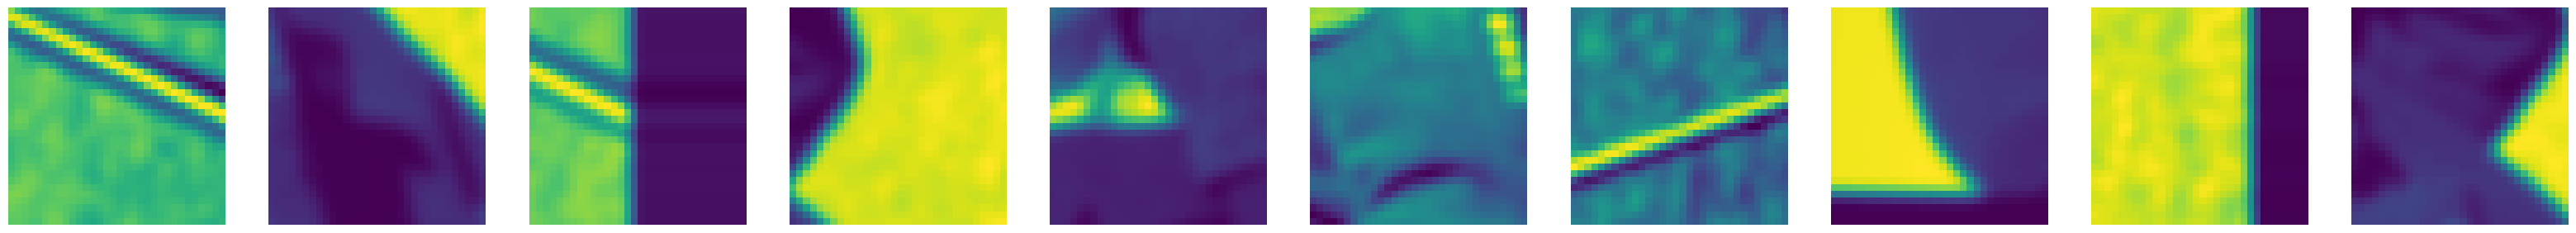

In [140]:
from kornia.feature import laf_from_center_scale_ori
from kornia_moons.feature import visualize_LAF


PS= 32
img1 = input[0][None]
points_filted = points[0][indices][:10]
print(points_filted.shape)
orient = PassLAF()#kornia.feature.LAFOrienter(PS)

print(img1.shape,out[0][0].shape)

scale_lafs = torch.ones(img1.shape[0],points_filted.shape[0],1,1)*PS
lafs1 = laf_from_center_scale_ori(points_filted[None],scale_lafs)
print('lafs1 ',lafs1.shape,input[0][None].shape)
lafs11 = orient(lafs1, input[0][None])
visualize_LAF(img1,lafs11,img_idx=0,figsize=(8,6))
# assert  torch.allclose(lafs1, lafs11),'sao diferentes'


lafs2 =laf_from_center_scale_ori(filtered_points[:10][None],scale_lafs)
print('lafs2 ',lafs2.shape,out[0][0][None].shape)
lafs22 = orient(lafs2, out[0][0][None])
visualize_LAF(out[0],lafs22,img_idx=0,figsize=(8,6))



print(img1.shape,out[0][0].shape)
import kornia
import matplotlib.pyplot as plt

def plot_patches_side_by_side(imgs_patches):
    num_imgs = imgs_patches.shape[0]
    print(num_imgs)
    fig, axs = plt.subplots(1, num_imgs, figsize=(num_imgs*4, 4))

    axs = axs.reshape((1, num_imgs))  # Ajustar a forma para matriz 2D com uma única linha

    for i in range(num_imgs):
        axs[0, i].imshow(kornia.tensor_to_image(imgs_patches[i]))
        axs[0, i].axis('off')

    plt.show()
    
# Exemplo de uso:
imgs_patches1 = kornia.feature.extract_patches_from_pyramid(img1, lafs11, PS)
plot_patches_side_by_side(imgs_patches1[0])

imgs_patches2 = kornia.feature.extract_patches_from_pyramid(out[0], lafs22, PS)
plot_patches_side_by_side(imgs_patches2[0])
